In [16]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import dataframe_image as dfi
from shapely import wkt
import sys
# !{sys.executable} -m pip install contextily
import contextily as ctx 
import matplotlib as mpl

In [17]:
FilePath = '/Users/hoperuse/summer2021internship/State Surplus/final_data.csv' # Replace with your own file path to csv of DOT parcels

# Data - Pandas DataFrame holding all parcel data in the final data universe, dropping leftover garbarge index columns
#   Setting index to mapc_id, a unique identifier for each parcel, to be used to match walkscore data
data = pd.read_csv(FilePath, index_col='mapc_id').drop(columns=['Unnamed: 0', 'index'])

# Removing the word "District" from the column holding the name of the corresponding districts for each parcel
# to prep for geomerge with State House district lines shapefile.
data['District'] = data['District'].str.replace(' District','')

# Adding null transit, walk, and bike score columns to be filled via the update function
data['TransitScore'] = np.nan
data['WalkScore'] = np.nan
data['BikeScore'] = np.nan

# Walkscores - Pandas DataFrame holding previously collected walk, bike, and transit score data for each parcel, which is then matched to each parcel
#   via the mapc_id field
walkscores = pd.read_csv('https://raw.githubusercontent.com/hochru557/summer2021internship/master/State%20Surplus/TransitScoresCompressed.csv',index_col='mapc_id')

# Updating data columns for scores using values from walkscore
data.update(walkscores)

# Reset index to normal, and returning mapc_id field to its original location
data = data.reset_index()

# Vacant - filtered dataset of just those parcels with land use codes of 973 (vacant, DOH) and 975 (vacant, DOT)
vacant = data[data['luc_adj_2'].isin([973,975])] 

In [54]:
# Creating a summary dataframe with overview data on data parcels, to be exported as .png file
pd.options.display.float_format = '{:20,.2f}'.format

summary = pd.DataFrame(columns = ['Categorization','Total Number of Parcels', 'Total Land Value','Total Area (acres)', 'Transit Friendly'])
summary.at[0,'Categorization'] = 'All Parcels'
summary.at[0, 'Total Number of Parcels'] = len(data.index)
summary.at[0, 'Total Land Value'] = data.land_value.sum()
summary.at[0, 'Total Area (acres)'] = data.lot_areaft.sum()/43560
summary.at[0, 'Transit Friendly'] = len(data[data.numTransitStops.notna()].index)


summary.at[1,'Categorization'] = 'Vacant 973/975'
summary.at[1, 'Total Number of Parcels'] = len(vacant.index)
summary.at[1, 'Total Land Value'] = vacant.land_value.sum()
summary.at[1, 'Total Area (acres)'] = vacant.lot_areaft.sum()/43560
summary.at[1, 'Transit Friendly'] = len(vacant[vacant.numTransitStops.notna()].index)

summary.to_csv('/Users/hoperuse/summer2021internship/State Surplus/TopTens/summary.csv')
summary

,Categorization,Total Number of Parcels,Total Land Value,Total Area (acres),Transit Friendly
0,All Parcels,14274,"7,258,840,205.00","516,580.73",3915
1,Vacant 973/975,599,"193,004,140.00","1,162.26",233


In [37]:
# aggData: returns a dataframe of total values by district for the input dataframe, can be used to get totals for different filtered dataframes
def aggData(d):
    # parcelsAgg: a dataframe to hold aggregate information on each districts total DOT-owned parcels
    parcelsAgg = pd.DataFrame(columns=['District','NumParcels','LandValue','AvgValue','TotalAreaFt', 'AvgArea','NumTransitFriendly','AvgWalkScore'])

    # List of all unique values for District from the original dot dataframe, to be iterated through in populating 
    # the parcelsAgg dataframe
    districts = d['District'].unique().flatten()

    for district in districts:
        # df - Filtered dataframe for the current value of district
        df = d[d['District'] == district]
        parcelsAgg.loc[district,'NumParcels'] = len(df.index)
        parcelsAgg.loc[district,'LandValue'] = df.land_value.sum()
        parcelsAgg.loc[district,'AvgValue'] = df.land_value.mean()
        parcelsAgg.loc[district,'TotalAreaFt'] = df.lot_areaft.sum()
        parcelsAgg.loc[district,'AvgArea'] = df.lot_areaft.mean()
        parcelsAgg.loc[district,'NumTransitFriendly'] = len(data[data.numTransitStops.notna()])
        parcelsAgg.loc[district,'AvgWalkScore'] = df.WalkScore.mean()
        
    parcelsAgg = parcelsAgg.reset_index()
    parcelsAgg = parcelsAgg.drop(columns=['District'])
    parcelsAgg = parcelsAgg.rename(columns={'index':'District'})
    parcelsAgg = parcelsAgg.dropna()
    return parcelsAgg

In [38]:
allParcels = aggData(data)
allParcels = allParcels.rename(columns = {'District': 'REP_DIST'})

print("Total Number of Parcels: ", len(data.index))
print("Total Land Area of Vacant Parcels (sq ft): ", str(data.lot_areaft.sum()))
print("Total Land Area of Vacant Parcels (acres): ", str(data.lot_areaft.sum()/43560))
print("Total Land Value of All Parcels: ", '$' + str(data.land_value.sum()))
print("Total Number of All Parcels with Transit Stops Closeby: ", len(data[data.numTransitStops.notna()]))

Total Number of Parcels:  14274
Total Land Area of Vacant Parcels (sq ft):  22502256456.659763
Total Land Area of Vacant Parcels (acres):  516580.7267369092
Total Land Value of All Parcels:  $7258840205.0
Total Number of All Parcels with Transit Stops Closeby:  3915


In [39]:
vacantParcels = aggData(vacant)
vacantParcels = vacantParcels.rename(columns = {'District': 'REP_DIST'})

print("Total Number of Vacant Parcels: ", len(vacant.index))
print("Total Land Area of Vacant Parcels (sq ft): ", str(vacant.lot_areaft.sum()))
print("Total Land Area of Vacant Parcels (acres): ", str(vacant.lot_areaft.sum()/43560))
print("Total Land Value of Vacant Parcels: ", '$' + str(vacant.land_value.sum()))
print("Total Number of DOT/DOH Parcels with Transit Stops Closeby: ", len(vacant[vacant.numTransitStops.notna()]))

Total Number of Vacant Parcels:  599
Total Land Area of Vacant Parcels (sq ft):  50627942.650744215
Total Land Area of Vacant Parcels (acres):  1162.2576366102896
Total Land Value of Vacant Parcels:  $193004140.0
Total Number of DOT/DOH Parcels with Transit Stops Closeby:  233


In [40]:
DoTDoH = aggData(data[data.luc_adj_2.isin([973,975])])
dh = data[data.luc_adj_2.isin([973,975])]
DoTDoH = DoTDoH.rename(columns = {'District': 'REP_DIST'})

print("Total Number of DOT/DOH Owned Vacant Parcels: ", len(data[data.luc_adj_2.isin([973,975])].index))
print("Total Land Area of DOT/DOH Parcels (sq ft): ", str(data[data.luc_adj_2.isin([973,975])].lot_areaft.sum()))
print("Total Land Area of DOT/DOH Parcels (acres): ", str(data[data.luc_adj_2.isin([973,975])].lot_areaft.sum() / 43560))
print("Total Land Value of DOT/DOH Parcels: ", '$' + str(data[data.luc_adj_2.isin([973,975])].land_value.sum()))
print("Total Number of DOT/DOH Parcels with Transit Stops Closeby: ", len(dh[dh.numTransitStops.notna()]))

Total Number of DOT/DOH Owned Vacant Parcels:  599
Total Land Area of DOT/DOH Parcels (sq ft):  50627942.650744215
Total Land Area of DOT/DOH Parcels (acres):  1162.2576366102896
Total Land Value of DOT/DOH Parcels:  $193004140.0
Total Number of DOT/DOH Parcels with Transit Stops Closeby:  233


In [57]:
# Creating image files for top 10 House Districts sorted on different measures regarding their contained parcels
pd.options.display.float_format = '{:.2f}'.format

# TOP 10 DISTRICTS BY TOTAL NUMBER OF ALL STATE OWNED PARCELS
df = allParcels.sort_values(by='NumParcels',ascending=False).head(10).reset_index(drop=True)
df= df[['REP_DIST', 'NumParcels']]
df.to_csv('/Users/hoperuse/summer2021internship/State Surplus/TopTens/TopNumParcels.csv',index=False)

# TOP 10 DISTRICTS BY TOTAL NUMBER OF VACANT (973,974,975) PARCELS
df = DoTDoH.sort_values(by='NumParcels',ascending=False).head(10).reset_index(drop=True)
df= df[['REP_DIST', 'NumParcels']]
df.to_csv('/Users/hoperuse/summer2021internship/State Surplus/TopTens/topNumParcelsVacant.csv',index=False)

# TOP 10 DISTRICTS BY TOTAL VALUE OF ALL STATE OWNED PARCELS
df=allParcels.sort_values(by='LandValue',ascending=False).head(10).reset_index(drop=True)
df= df[['REP_DIST', 'LandValue','AvgValue']]
df.to_csv('/Users/hoperuse/summer2021internship/State Surplus/TopTens/topLandValue.csv',index=False)

# TOP 10 DISTRICTS BY TOTAL VALUE OF ALL VACANT (973,974,975) OWNED PARCELS
df=DoTDoH.sort_values(by='LandValue',ascending=False).head(10).reset_index(drop=True)
df= df[['REP_DIST', 'LandValue','AvgValue']]
df.to_csv('/Users/hoperuse/summer2021internship/State Surplus/TopTens/topLandValueVacant.csv',index=False)

# TOP 10 DISTRICTS BY AVERAGE STATE OWNED PARCEL VALUE
df=allParcels.sort_values(by='AvgValue',ascending=False).head(10).reset_index(drop=True)
df= df[['REP_DIST', 'AvgValue','LandValue']]
df.to_csv('/Users/hoperuse/summer2021internship/State Surplus/TopTens/topAvgValue.csv',index=False)

# TOP 10 DISTRICTS BY TOTAL STATE OWNED PARCEL AREA
df=allParcels.sort_values(by='TotalAreaFt',ascending=False).head(10).reset_index(drop=True)
df= df[['REP_DIST', 'TotalAreaFt','AvgArea']]
df['TotalAreaFt'] = df['TotalAreaFt'] / 43560
df.to_csv('/Users/hoperuse/summer2021internship/State Surplus/TopTens/topTotalAreaAll.csv',index=False)

# TOP 10 DISTRICTS BY TOTAL VACANT OWNED PARCEL AREA
df=DoTDoH.sort_values(by='TotalAreaFt',ascending=False).head(10).reset_index(drop=True)
df= df[['REP_DIST', 'TotalAreaFt','AvgArea']]
df['TotalAreaFt'] = df['TotalAreaFt'] / 43560
df = df.rename(columns={'TotalAreaFt':'Total Acres'})
df['Total Acres'] = df['Total Acres'].astype(int)
df.to_csv('/Users/hoperuse/summer2021internship/State Surplus/TopTens/topTotalAreaVacant973_975.csv',index=False)


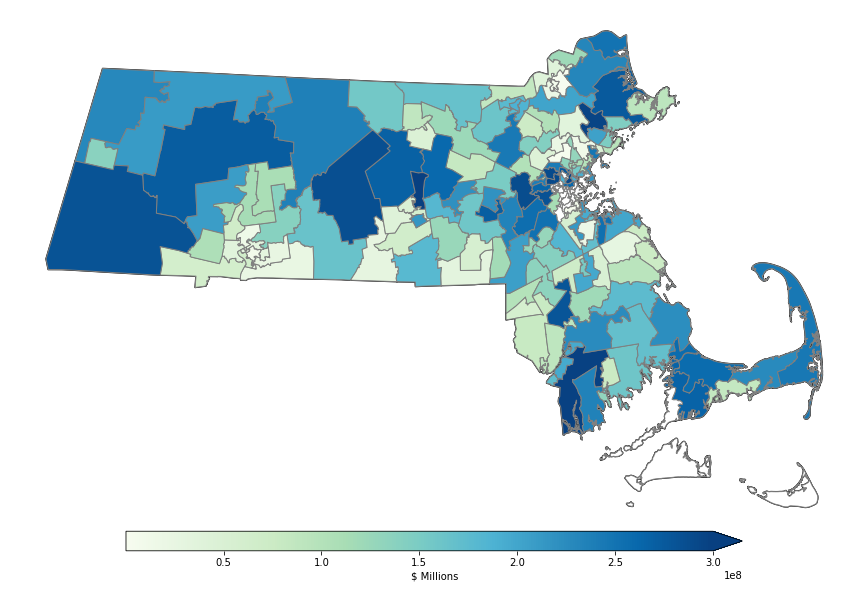

In [42]:
# MA House Leg Districts (https://www.mass.gov/info-details/massgis-data-massachusetts-house-legislative-districts#downloads-)
houseDistricts = gpd.read_file('/Users/hoperuse/summer2021internship/State Surplus/house2012/HOUSE2012_POLY.shp')

pd.options.display.float_format = '${:20,.2f}'.format

# Rename District column to match name in houseDistricts file
parcelsAgg = allParcels.rename(columns = {'District': 'REP_DIST'})

# Geospatial merge of parcelsAgg and houseDistricts for mapping
merged = houseDistricts.merge(allParcels, on = 'REP_DIST', how='left')

# Mapping total value of all parcels by House district
fig, ax = plt.subplots(figsize=(20,10))
houseDistricts.boundary.plot(ax=ax,edgecolor ='black',zorder=1)
vmin, vmax = min(allParcels['LandValue']), max(allParcels['LandValue'])
merged.plot(column='LandValue',
        cmap='GnBu',
        ax=ax,
        edgecolor='gray',
        missing_kwds = {"color":"white"})
ax.axis('off')

sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=vmin,vmax=vmax))
cbar = fig.colorbar(sm,orientation="horizontal", fraction=0.036, pad=0, aspect = 30,extend='max')
cbar.set_label("$ Millions")
fig.savefig('/Users/hoperuse/summer2021internship/State Surplus/Graphics/AllParcelsValueMap.png',dpi=300)

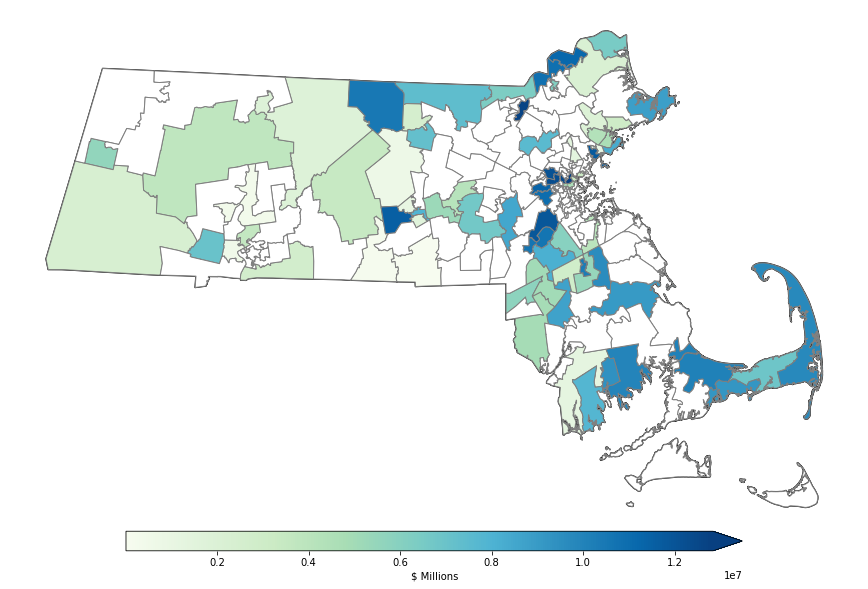

In [43]:
# MA House Leg Districts (https://www.mass.gov/info-details/massgis-data-massachusetts-house-legislative-districts#downloads-)
houseDistricts = gpd.read_file('/Users/hoperuse/summer2021internship/State Surplus/house2012/HOUSE2012_POLY.shp')

pd.options.display.float_format = '${:20,.2f}'.format

# Geospatial merge of parcelsAgg and houseDistricts for mapping
merged = houseDistricts.merge(DoTDoH, on = 'REP_DIST', how='left')

# Mapping total value of all parcels by House district
fig, ax = plt.subplots(figsize=(20,10))
houseDistricts.boundary.plot(ax=ax,edgecolor ='black',zorder=1)
vmin, vmax = min(DoTDoH['LandValue']), max(DoTDoH['LandValue'])
merged.plot(column='LandValue',
        cmap='GnBu',
        ax=ax,
        edgecolor='gray',
        missing_kwds = {"color":"white"})
ax.axis('off')

sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=vmin,vmax=vmax))
cbar = fig.colorbar(sm,orientation="horizontal", fraction=0.036, pad=0, aspect = 30,extend='max')
cbar.set_label("$ Millions")
fig.savefig('/Users/hoperuse/summer2021internship/State Surplus/Graphics/973_975_LandValueMap.png',dpi=300)

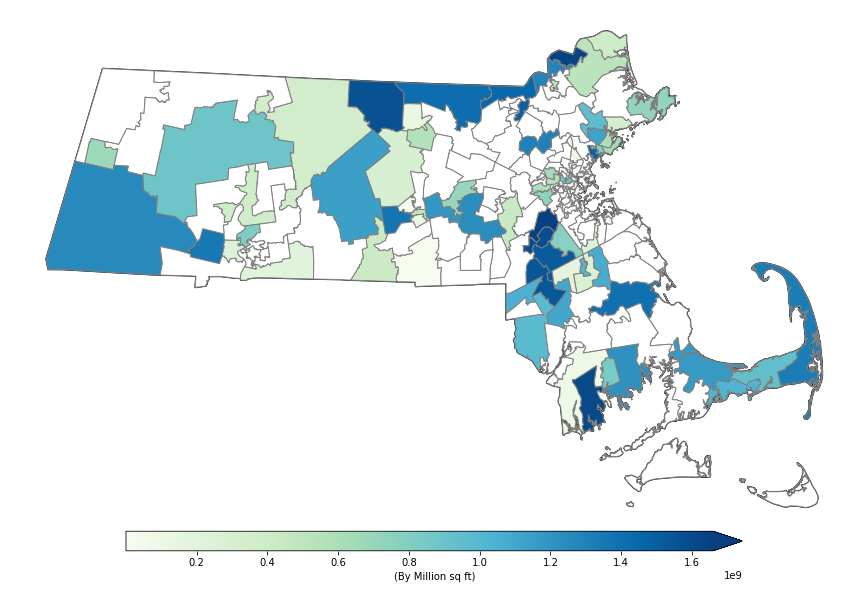

In [44]:
# Mapping total area (square feet) of ALL parcels by district
pd.options.display.float_format = '{:20,.2f}'.format

fig, ax = plt.subplots(figsize=(20,10))
houseDistricts.boundary.plot(ax=ax,edgecolor ='black',zorder=1)
vmin, vmax = min(allParcels.TotalAreaFt), max(allParcels.TotalAreaFt)
merged.plot(column='TotalAreaFt',
        cmap='GnBu',
        ax=ax,
        edgecolor='gray',
        missing_kwds = {"color":"white"})
ax.axis('off')

sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=vmin,vmax=vmax))
cbar=fig.colorbar(sm,orientation="horizontal", fraction=0.036, pad=0, aspect = 30, extend='max')
cbar.set_label("(By Million sq ft)")  # horizontal colorbar

fig.savefig('/Users/hoperuse/summer2021internship/State Surplus/Graphics/TotalAreaAll.png',dpi=300)

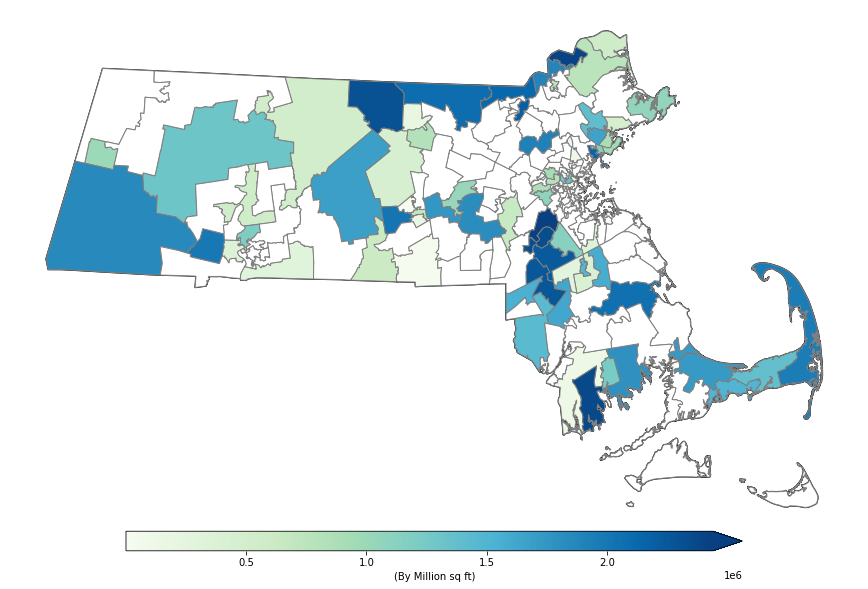

In [45]:
# Mapping total area (square feet) of 973, 974, 975 parcels by district
pd.options.display.float_format = '{:20,.2f}'.format
merged = houseDistricts.merge(vacantParcels, on = 'REP_DIST', how='left')

fig, ax = plt.subplots(figsize=(20,10))
houseDistricts.boundary.plot(ax=ax,edgecolor ='black',zorder=1)
vmin, vmax = min(DoTDoH.TotalAreaFt), max(DoTDoH.TotalAreaFt)
merged.plot(column='TotalAreaFt',
        cmap='GnBu',
        ax=ax,
        edgecolor='gray',
        missing_kwds = {"color":"white"})
ax.axis('off')

sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=vmin,vmax=vmax))
cbar=fig.colorbar(sm,orientation="horizontal", fraction=0.036, pad=0, aspect = 30, extend='max')
cbar.set_label("(By Million sq ft)")  # horizontal colorbar

fig.savefig('/Users/hoperuse/summer2021internship/State Surplus/Graphics/973_975_TotalAreaVacantmap.png',dpi=300)

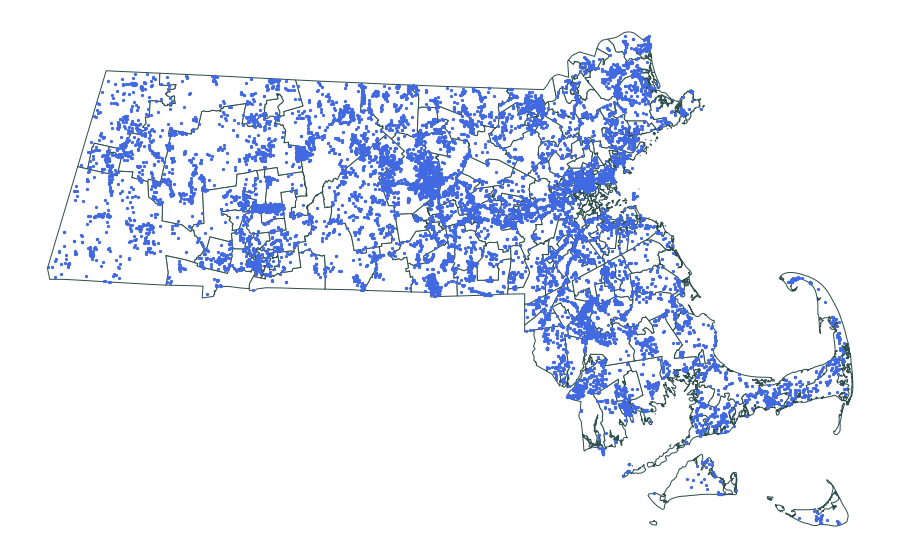

In [46]:
# MAPPING ALL STATE OWNED LAND PARCELS

# Converting final_data into a GeoPandas DataFrame
geometry = data['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(data,geometry=geometry,crs = 'EPSG:26986') # Matching the new gdf crs to the crs of houseDistricts
gdf['geometry'] = gdf['geometry'].centroid

fig, ax = plt.subplots(figsize=(20,10))
ax.set_aspect('equal')
base = houseDistricts.plot(ax=ax, color='white', edgecolor='darkslategrey')

gdf.plot(ax=ax, marker='o', color='royalblue', markersize=5,legend=False)
ax.axis('off')

fig.savefig('/Users/hoperuse/summer2021internship/State Surplus/Graphics/AllParcels.png',dpi=300)

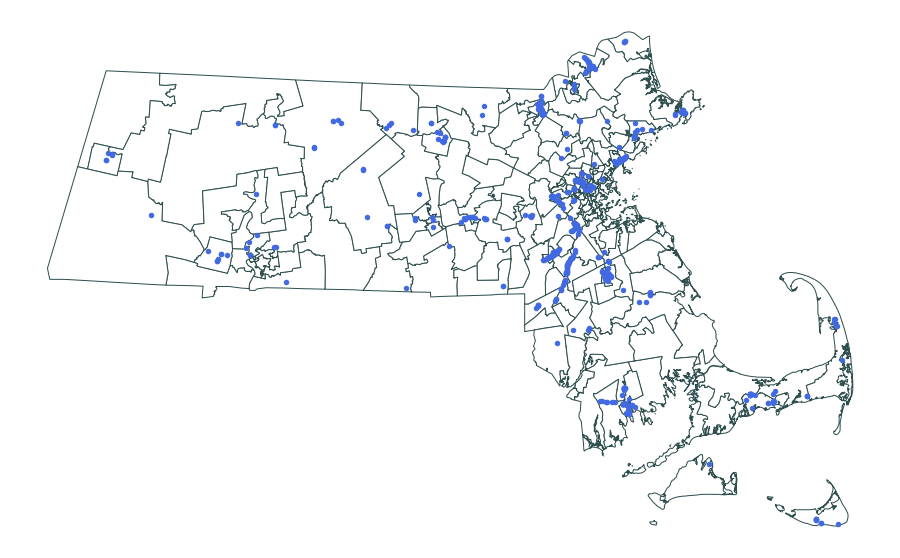

In [47]:
# MAPPING ALL VACANT (973, 975) STATE OWNED PARCELS ACROSS MA

# Converting final_data into a GeoPandas DataFrame
vacant = data[data.luc_adj_2.isin([973,975])]
vMap = gpd.GeoDataFrame(vacant,geometry=geometry,crs = 'EPSG:26986') # Matching the new gdf crs to the crs of houseDistricts
vMap.geometry = vMap.geometry.centroid

fig, ax = plt.subplots(figsize=(20,10))
ax.set_aspect('equal')
base = houseDistricts.plot(ax=ax, color='white', edgecolor='darkslategrey')

vMap.plot(ax=ax, marker='o', color='royalblue', markersize=20,legend=False)
ax.axis('off')

fig.savefig('/Users/hoperuse/summer2021internship/State Surplus/Graphics/973_975ParcelsMap.png',dpi=300)

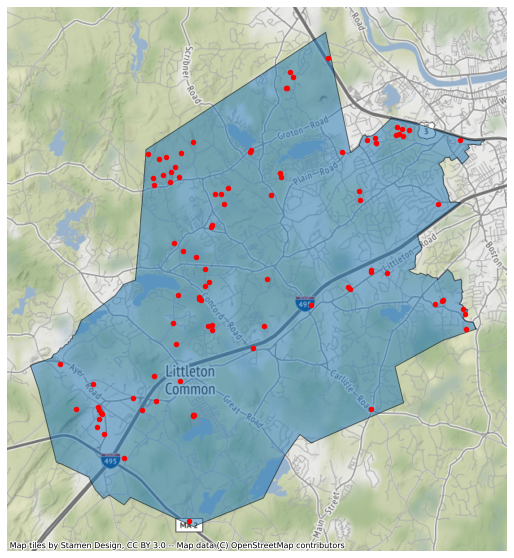

In [48]:
# Analysis specific to Chair Arceiro's District
arceiro = houseDistricts[houseDistricts.REP_DIST == '2nd Middlesex']
arceiro = arceiro.to_crs(epsg=3857)

ax = arceiro.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

arceiro1 = gdf[gdf.District == '2nd Middlesex']
arceiro1 = arceiro1.to_crs(epsg=3857)

arceiro1.plot(ax=ax, marker='o', color='red', markersize=20,legend=False,zorder=3)
ctx.add_basemap(ax,zoom=12)
ax.set_axis_off()

plt.savefig('/Users/hoperuse/summer2021internship/State Surplus/Graphics/Arceiro.png')
